In [1]:
import tensorflow as tf
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../SoundNet-tensorflow/')
from main import *
from util import load_from_list
%matplotlib inline

### Load style and content

In [2]:
music_dir = "/data2/kaylee/kaylee/music-score-gen/data/emotifymusic"

# try classical melody in electronic tone
emotion = 'joyful_activation'
content = '88'
style = '296'

# try lyrics
# emotion = 'joyful_activation'
content = '173'
style = '212'

# percussive beat: tension 211
CONTENT_FILENAME = "%s/%s/%s.mp3" %(music_dir, emotion, content)
STYLE_FILENAME = "%s/%s/%s.mp3" %(music_dir, emotion, style)

In [3]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [4]:
# config for sound net
config = {
    'tfhub_module':'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1', # link to pretrained inception model
    'bottleneck_dir':'data/img_bottlenecks/', # for image feature representations
    'image_dir':'data/testImages_artphoto/', # 
    'summaries_dir':'logging/summaries/',
    'num_training_steps':1000000,
    'train_batch_size':1, # should be same as batch_size because flags are different for sound net and image net :)
    'eval_step_interval':1,
    'testing_percentage':10,
    'validation_percentage':10,
    'phase':'train',
    'param_g_dir':'../models/sound8.npy', # TODO: change to correct relative path (we r one dir up)
    'learning_rate':1e-3,
    'batch_size':1,
    'num_noise_samples':0,
    'hidden_dim':1024,
    'name_scope': 'SoundNet', # for things in sound net
    'eps':1e-5,
    'load_size':22050*4,
}

# Set up the pre-trained audio model.
param_G = np.load(config['param_g_dir'], encoding='latin1').item() \
        if config['phase'] in ['finetune', 'extract', 'train'] \
        else None
        
# find content and style representations

# Add the new embedding that we'll be training.
g = tf.Graph()
with g.as_default():
    
    # set up sound graph
    model = Model(config=config, param_G=param_G)
    song_emb = model.fetch_scene_embedding(config['hidden_dim'])

with tf.Session(graph=g) as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    # load from list and eval content and style
    loaded_content_file = load_from_list([CONTENT_FILENAME], config)
    loaded_style_file = load_from_list([STYLE_FILENAME], config)
    content_features = sess.run([song_emb], feed_dict={model.label_sound_placeholder:loaded_content_file})[0]
    style_features = sess.run([song_emb], feed_dict={model.label_sound_placeholder:loaded_style_file})[0]

In [5]:
# create new graph for this loss
with g.as_default():
    
    # set up sound graph AGAIN
    ######################
    # copy soundnet here #
    ######################
    x = tf.Variable(np.random.randn(1,config['load_size'],1,1).astype(np.float32), name="x")
    
    layers = {}
            
    # Stream one: conv1 ~ conv7
    layers[1] = conv2d(x, 1, 16, k_h=64, d_h=2, p_h=32, name_scope='conv1')
    layers[2] = batch_norm(layers[1], 16, config['eps'], name_scope='conv1')
    layers[3] = relu(layers[2], name_scope='conv1')
    layers[4] = maxpool(layers[3], k_h=8, d_h=8, name_scope='conv1')

    layers[5] = conv2d(layers[4], 16, 32, k_h=32, d_h=2, p_h=16, name_scope='conv2')
    layers[6] = batch_norm(layers[5], 32, config['eps'], name_scope='conv2')
    layers[7] = relu(layers[6], name_scope='conv2')
    layers[8] = maxpool(layers[7], k_h=8, d_h=8, name_scope='conv2')

    layers[9] = conv2d(layers[8], 32, 64, k_h=16, d_h=2, p_h=8, name_scope='conv3')
    layers[10] = batch_norm(layers[9], 64, config['eps'], name_scope='conv3')
    layers[11] = relu(layers[10], name_scope='conv3')

    layers[12] = conv2d(layers[11], 64, 128, k_h=8, d_h=2, p_h=4, name_scope='conv4')
    layers[13] = batch_norm(layers[12], 128, config['eps'], name_scope='conv4')
    layers[14] = relu(layers[13], name_scope='conv4')

    layers[15] = conv2d(layers[14], 128, 256, k_h=4, d_h=2, p_h=2, name_scope='conv5')
    layers[16] = batch_norm(layers[15], 256, config['eps'], name_scope='conv5')
    layers[17] = relu(layers[16], name_scope='conv5')
    layers[18] = maxpool(layers[17], k_h=4, d_h=4, name_scope='conv5')

    layers[19] = conv2d(layers[18], 256, 512, k_h=4, d_h=2, p_h=2, name_scope='conv6')
    layers[20] = batch_norm(layers[19], 512, config['eps'], name_scope='conv6')
    layers[21] = relu(layers[20], name_scope='conv6')

    layers[22] = conv2d(layers[21], 512, 1024, k_h=4, d_h=2, p_h=2, name_scope='conv7')
    
    tabula_emb = tf.expand_dims(tf.reduce_sum(layers[22], axis=1), axis=1)
    
    ########################
    # compute loss #
    ########################
    
    ALPHA = 1e-2
    content_loss = ALPHA * 2 * tf.nn.l2_loss(tabula_emb - content_features)
    
    style_loss = 0
    N_FILTERS = 1024 # out_ch of conv2d
    N_SAMPLES = 1 # ?
    
    # find style gram
    features = np.reshape(style_features, (-1, N_FILTERS))
    style_gram = np.matmul(features.T, features) / N_SAMPLES

    tabula_feats = tf.reshape(tabula_emb, (-1, N_FILTERS))
    tabula_gram = tf.matmul(tf.transpose(tabula_feats), tabula_feats) / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(tabula_gram - style_gram)

     # Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 300})
        
    # Optimization; TODO: change
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print('Final loss:', loss.eval())
        result = x.eval()
    
with tf.Session(graph=g) as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.000000
  Number of iterations: 1
  Number of functions evaluations: 6
Final loss: 3.2642449e-09


In [8]:
sound_sample, _ = load_audio(CONTENT_FILENAME)
print(sound_sample.shape)
result.shape[1] / 2

(2, 2647296)


44100.0

In [15]:
from scipy.io.wavfile import write

# scaled = np.int16(result/np.max(np.abs(result)) * 32767)
write('test.wav', 400, scaled)
result

error: ushort format requires 0 <= number <= (0x7fff * 2 + 1)

In [11]:
# modify result into sound file
result.shape


# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'outputs/%s_%s_%s_%s.wav' %(emotion, content, style, 'sound_net')
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

(1, 88200, 1, 1)

In [6]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [7]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, :N_SAMPLES]

### Visualize spectrograms for content and style tracks

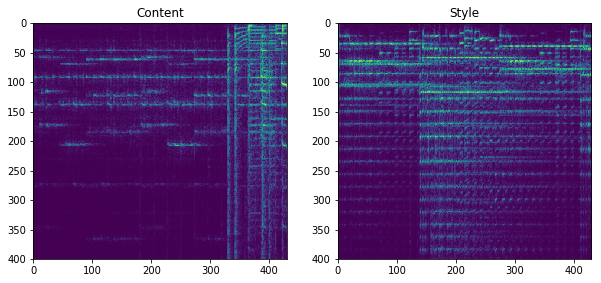

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

### Compute content and style feats

In [131]:
N_FILTERS = 4096

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std
    
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    net = tf.nn.relu(conv)

    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    
    features = np.reshape(style_features, (-1, N_FILTERS))
    style_gram = np.matmul(features.T, features) / N_SAMPLES

### Optimize

In [144]:
from sys import stderr

ALPHA= 1e-2
BETA = 100
learning_rate= 1e-3
iterations = 100

result = None
with tf.Graph().as_default():

    # Build graph with variable input
#     x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    
    net = tf.nn.relu(conv)

    content_loss = ALPHA * 2 * tf.nn.l2_loss(net - content_features)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

     # Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 300})
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print('Final loss:', loss.eval())
        result = x.eval()

Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 101.160980
  Number of iterations: 110
  Number of functions evaluations: 130
Final loss: 101.16098


### Invert spectrogram and save the result

In [145]:
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'outputs/%s_%s_%s_%s.wav' %(emotion, content, style , 'log_pois_loss_style_beta_100')
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

In [142]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [147]:
print(OUTPUT_FILENAME)
display(Audio('outputs/joyful_activation_88_296_log_pois_loss_style_1.wav'))

outputs/joyful_activation_88_296_log_pois_loss_style_beta_100.wav


### Visualize spectrograms

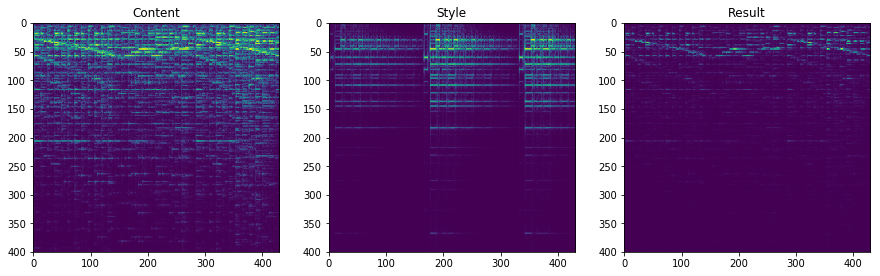

In [148]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.show()